# Single-qubit VQE demo

In this notebook, we consider a simple single-qubit VQE example to compare "vanilla" gradient descent and quantum natural gradient. 

We use several different methods to visualize the results: 
1. tracking the optimization path in the energy space,
2. tracking the optimization path in the parameter space using a contour plot, and 
3. tracking the optimization path in the state space on the Bloch sphere. 

We consider the following single-qubit Hamiltonian: X + Z. 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl

import numpy as np
import scipy as sp

import pennylane as qml

import qutip as qt
from qutip import Bloch
from qutip.expect import expect
from qutip.operators import sigmax, sigmay, sigmaz

import sys
sys.path.append('../')
from run_vqe import *

In [2]:
# Define the quantum simulator
dev = qml.device("default.qubit", wires=1)

# Define the VQE ansatz
def circuit(params, wires=0):
    qml.RX(params[0], wires=wires)
    qml.RY(params[1], wires=wires)

# Define the VQE problem/Hamiltonian
hamiltonian = qml.Hamiltonian([1, 1], [qml.PauliX(0), qml.PauliZ(0)])
cost_fn = qml.VQECost(circuit, hamiltonian, dev)

In [3]:
# Set initial VQE circuit parameters
init_params = np.array([3.97507603, 3.00854038])    

In [4]:
# Define optimizer settings
max_iter = 500
step_size = 0.01
conv_tol = 1e-06

In [5]:
# Run VQE with gradient descent
gd_energies, gd_nsteps, gd_states, gd_params = run_single_qubit_vqe(cost_fn=cost_fn, 
                                                                    dev=dev, 
                                                                    max_iter=max_iter, 
                                                                    initial_params=init_params, 
                                                                    opt_name='GradientDescentOptimizer', 
                                                                    step_size=step_size, 
                                                                    conv_tol=conv_tol)

Iteration = 0,  Energy = 0.56743624 Ha,  Convergence parameter = 0.00973536 Ha
Iteration = 20,  Energy = 0.38709233 Ha,  Convergence parameter = 0.00821261 Ha
Iteration = 40,  Energy = 0.24420954 Ha,  Convergence parameter = 0.00616395 Ha
Iteration = 60,  Energy = 0.14079686 Ha,  Convergence parameter = 0.00435028 Ha
Iteration = 80,  Energy = 0.06758408 Ha,  Convergence parameter = 0.00314443 Ha
Iteration = 100,  Energy = 0.01128048 Ha,  Convergence parameter = 0.00262544 Ha
Iteration = 120,  Energy = -0.04175219 Ha,  Convergence parameter = 0.00278160 Ha
Iteration = 140,  Energy = -0.10499504 Ha,  Convergence parameter = 0.00361450 Ha
Iteration = 160,  Energy = -0.19195848 Ha,  Convergence parameter = 0.00511056 Ha
Iteration = 180,  Energy = -0.31444953 Ha,  Convergence parameter = 0.00708743 Ha
Iteration = 200,  Energy = -0.47706980 Ha,  Convergence parameter = 0.00900220 Ha
Iteration = 220,  Energy = -0.66993027 Ha,  Convergence parameter = 0.01001574 Ha
Iteration = 240,  Energy = -

In [6]:
gd_energies = np.array(gd_energies)
gd_params = np.array(gd_params)
gd_states = np.array(gd_states)

In [7]:
# Run VQE with gradient descent
qng_energies, qng_nsteps, qng_states, qng_params = run_single_qubit_vqe(cost_fn=cost_fn, 
                                                                    dev=dev, 
                                                                    max_iter=max_iter, 
                                                                    initial_params=init_params, 
                                                                    opt_name='QNGOptimizer', 
                                                                    step_size=step_size, 
                                                                    conv_tol=conv_tol,
                                                                    diag_approx=False)

Iteration = 0,  Energy = 0.51052556 Ha,  Convergence parameter = 0.06664604 Ha
Iteration = 20,  Energy = -0.90729965 Ha,  Convergence parameter = 0.05006082 Ha
Iteration = 40,  Energy = -1.35504644 Ha,  Convergence parameter = 0.00713113 Ha
Iteration = 60,  Energy = -1.40833787 Ha,  Convergence parameter = 0.00072399 Ha
Iteration = 80,  Energy = -1.41364035 Ha,  Convergence parameter = 0.00007078 Ha
Iteration = 100,  Energy = -1.41415774 Ha,  Convergence parameter = 0.00000689 Ha

Final value of the energy = -1.41420585
Number of iterations =  117


In [8]:
qng_energies = np.array(qng_energies)
qng_params = np.array(qng_params)
qng_states = np.array(qng_states)

After gathering the optimization data, we first plot the energy histories:

We first calculate the exact ground state of the single qubit Hamiltonian for reference:

In [9]:
paulix = np.array([[0,1], [1,0]])
pauliz = np.array([[1,0], [0,-1]])

qubit_hamiltonian = np.add(paulix, pauliz)

exact_energy = np.min(np.linalg.eigvalsh(qubit_hamiltonian))
print(exact_energy)

-1.4142135623730951


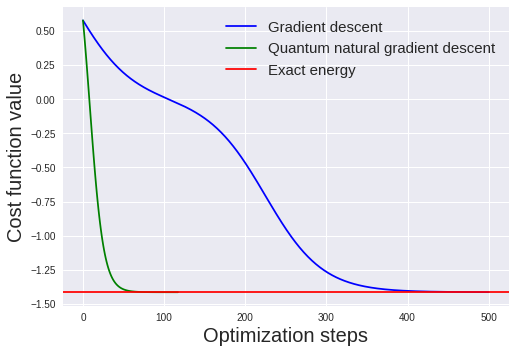

In [10]:
# Track energy history for both optimization methods
plt.style.use("seaborn")
ax = plt.axes()

plt.plot(gd_energies, "b", label="Gradient descent")
plt.plot(qng_energies, "g", label="Quantum natural gradient descent")

plt.ylabel("Cost function value", fontsize=20)
plt.xlabel("Optimization steps", fontsize=20)

ax.axhline(y=exact_energy, label='Exact energy', color='r')

plt.legend(fontsize=15)
plt.show()

Since we only have two VQE circuit parameters, we can also visualize the objective function landscape with respect to the two parameters. 

We first generate grid points to compute the objective function landscape. We've pre-computed the landscape but also provide the code below to generate it.

In [11]:
# Visualize the optimization path in the parameter space using a contour plot

# First scan over the two variational parameters
ntheta_first, ntheta_second = (100, 100)
theta_first = np.linspace(0., 2*np.pi, ntheta_first)
theta_second = np.linspace(0., 2*np.pi, ntheta_second)
theta_firstv, theta_secondv = np.meshgrid(theta_first, theta_second, indexing='ij')
# fn_values = np.zeros((ntheta_first, ntheta_second))

# for i in range(ntheta_first):
#     for j in range(ntheta_second):
#         fn_values[i, j] = cost_fn([theta_firstv[i,j], theta_secondv[i,j]])
        
# Save then load parameter space if preferred
# np.save('param_landscape.npy', fn_values)
fn_values = np.load('param_landscape.npy')

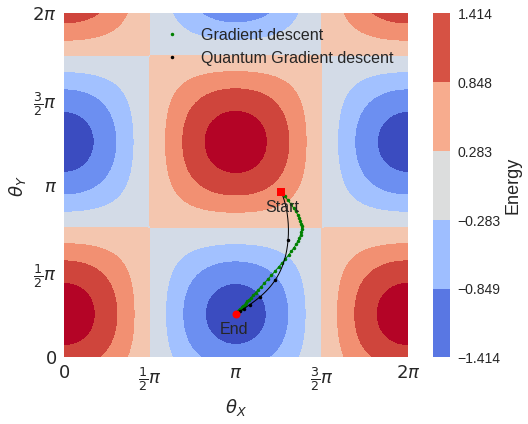

In [12]:
# Plot landscape
plt.style.use("seaborn")
fontsize = 18

fig, axes = plt.subplots(figsize=(8, 6))
cmap = plt.cm.get_cmap("coolwarm")
contour_plot = plt.contourf(theta_firstv, theta_secondv, fn_values, extend='both',
                            cmap=cmap, vmin=np.min(fn_values))
# Configure colorbar
m = plt.cm.ScalarMappable(cmap=cm.coolwarm)
m.set_array(fn_values)
m.set_clim(np.min(fn_values), np.max(fn_values))
cbar = plt.colorbar(m, boundaries=np.linspace(np.min(fn_values), np.max(fn_values), 6))
cbar.ax.tick_params(labelsize=14)
cbar.ax.set_ylabel("Energy", fontsize=fontsize)


#### Gradient descent ####
gd_color = 'g'
plt.plot(gd_params[::10, 0], gd_params[::10, 1], '.', color=gd_color,
         linewidth=1, label='Gradient descent')
plt.plot(gd_params[::1, 0], gd_params[::1, 1], '-', color=gd_color, linewidth=1)


#### Quantum Natural Gradient descent ####
# Optimization path (plot every 10th point)
plt.plot(qng_params[::10, 0], qng_params[::10, 1], 'k.', linewidth=1, label='Quantum Gradient descent')
# Plot path as a smooth line
plt.plot(qng_params[::1, 0], qng_params[::1, 1], 'k-', linewidth=1)

# Annotate Start of optimization
plt.plot(qng_params[0, 0], qng_params[0, 1], 'rs',  markersize=8)
plt.annotate('Start', (qng_params[0, 0]-0.3, qng_params[0, 1]-0.35), fontsize=16)

# Annotate End of optimization
plt.plot(qng_params[-1, 0], qng_params[-1, 1], 'ro',  markersize=8)
plt.annotate('End', (qng_params[-1, 0]-0.3, qng_params[-1, 1]-0.35), fontsize=16)

plt.legend(fontsize=16)

axes.set_xticks([0., 0.5*np.pi, np.pi, 1.5*np.pi, 2*np.pi])
axes.set_yticks([0., 0.5*np.pi, np.pi, 1.5*np.pi, 2*np.pi])

axes.set_xticklabels(["$0$", r"$\frac{1}{2}\pi$",
                     r"$\pi$", r"$\frac{3}{2}\pi$", r"$2\pi$"], fontsize=fontsize)
axes.set_yticklabels(["$0$", r"$\frac{1}{2}\pi$",
                     r"$\pi$", r"$\frac{3}{2}\pi$", r"$2\pi$"], fontsize=fontsize)

plt.xlabel(r'$\theta_X$', fontsize=fontsize)        
plt.ylabel(r'$\theta_Y$', fontsize=fontsize)        

axes.set_aspect('equal')

plt.tight_layout()

# plt.savefig('single_qubit_vqe_landscape.pdf', format='pdf')

Lastly, we can visualize the optimization path on the Bloch sphere. To do so, we first convert all the state vectors in the state history to corresponding coordinates on the Bloch sphere.

In [13]:
### Convert state vectors into coordinates on Bloch sphere ###

coords_x_gd = []
coords_y_gd = []
coords_z_gd = []

for psi in gd_states:
    psi = psi / np.linalg.norm(psi)

    qobj = [qt.Qobj(psi)]
    
    x = expect(sigmax(), qobj)
    y = expect(sigmay(), qobj)
    z = expect(sigmaz(), qobj)
    
    coords_x_gd.append(x[0])
    coords_y_gd.append(y[0])
    coords_z_gd.append(z[0])
    
# Repeat process for QNG
coords_x_qng = []
coords_y_qng = []
coords_z_qng = []

for psi in qng_states:
    psi = psi / np.linalg.norm(psi)

    qobj = [qt.Qobj(psi)]
    
    x = expect(sigmax(), qobj)
    y = expect(sigmay(), qobj)
    z = expect(sigmaz(), qobj)
    
    coords_x_qng.append(x[0])
    coords_y_qng.append(y[0])
    coords_z_qng.append(z[0])

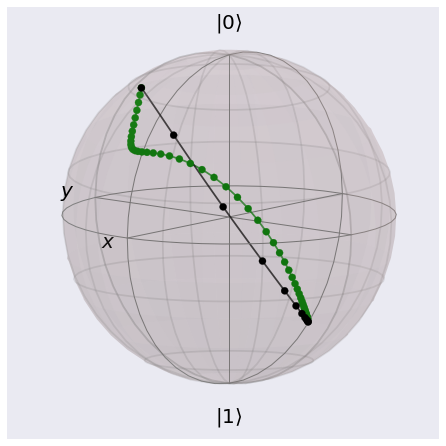

In [14]:
### Settings for Bloch sphere visualization ###

b = Bloch()
b.sphere_alpha = 0.2
b.figsize = [6, 6]
b.point_color = ['g', 'g', 'k', 'k']
b.point_marker = 'o'
b.point_size = [50]

# Add every 10th point for gradient descent
b.add_points([coords_x_gd[::10], coords_y_gd[::10], coords_z_gd[::10]])

# Add smooth line for gradient descent
b.add_points([coords_x_gd, coords_y_gd, coords_z_gd], 'l')

# Add every 10th point for quantum natural gradient descent
b.add_points([coords_x_qng[::10], coords_y_qng[::10], coords_z_qng[::10]])

# Add smooth line for quantum natural gradient descent
b.add_points([coords_x_qng, coords_y_qng, coords_z_qng], 'l')

# Rotate the Bloch sphere for clear visualization
b.view = [50, -10]

b.show()

# b.save('opt_paths_bloch.png', format='png')

Above, we show the optimization path in the state space for gradient descent in green and quantum natural gradient in black. We can clearly see how using quantum natural gradient, the optimizer can take a path that tightly "hugs" the curvature of the Bloch sphere.